Would it be possible to include all the features values in the decission process of buying apart from the tp and sl limits, instead of the model pred.
  

In [1]:

from src.core.backtest.backtesting import backtest_numba, backtest_pure_python, backtest_numba_buy_and_sell

In [2]:
#Deserialize
import pickle
import pandas as pd
from src.modules.paths import get_project_root
from src.core.features.utils import feature_pipeline, add_domain_features
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
with open("wow_20.pickle" ,'rb') as f:
    model = pickle.load(f)
import optuna
import numpy as np

In [37]:
cut_off_date ="2021-11-07 21:28:00"
cut_off_date ="2021-09-07 21:28:00"
#cut_off_date ="2021-10-23 21:28:00"
crypto_to_optimize=["bcheur","compeur","xdgeur","xlmeur"]
crypto_to_evaluate = ["etheur", "algoeur", "bateur", "adaeur","xrpeur"]
columns_features = [col for col in feature_pipeline(pd.read_csv(get_project_root() / "data" / "historical" / "etheur.csv"), include_target=False)[0].columns if col.startswith("feature")]

In [38]:



df_all = pd.read_feather(get_project_root() / "data" / "training" / "training_all_crypto_30_11_2021.feather")
df = df_all[df_all.date>cut_off_date].copy()

In [39]:
# how many features?
features = [col for col in df.columns if col.startswith("feature")]

In [40]:
def add_preds(df, features):
    # get dict of distr
    dict_feature_metrics = {feature: df[feature].quantile([0.05, 0.95]).values for feature in features}
    # Get correlation with target
    df_norm = (df[features]-df[features].mean())/df[features].std()
    df_norm["target"] = df["target_20"]
    corr = df_norm.corr()["target"].iloc[:-1]
    # which features are positive correlated or negative
    list_sell_pos = list(corr[corr>0].index)
    list_sell_neg = list(corr[corr<0].index)
    df["preds"] = add_buy_sell_actions(df, list_sell_pos, list_sell_neg, dict_feature_metrics)
    return df
    
def add_buy_sell_actions(df, list_sell_pos, list_sell_neg, dict_feature_metrics):
    """Adding buy sell based on individual feature"""
    df_preds_sell_pos = pd.DataFrame(index=df.index)
    for col in df[list_sell_pos].columns:
        df_preds_sell_pos[f"preds_{col}"] = 0
        mask = (df[col]>dict_feature_metrics[col][1])
        df_preds_sell_pos.loc[mask,f"preds_{col}"] = 1

    for col in df[list_sell_pos].columns:
        mask = (df[col]<dict_feature_metrics[col][0])
        df_preds_sell_pos.loc[mask,f"preds_{col}"] = -1

    df_preds_sell_neg = pd.DataFrame(index=df.index)
    for col in df[list_sell_neg].columns:
        df_preds_sell_neg[f"preds_{col}"] = 0
        mask = (df[col]>dict_feature_metrics[col][1])
        df_preds_sell_neg.loc[mask,f"preds_{col}"] = -1

    for col in df[list_sell_neg].columns:
        mask = (df[col]<dict_feature_metrics[col][0])
        df_preds_sell_neg.loc[mask,f"preds_{col}"] = 1
        
    df_processed = pd.concat([df_preds_sell_pos, df_preds_sell_neg], axis=1)
    preds = df_processed.mean(axis=1)
    return preds

In [41]:
#custom preds handcoded
df = add_preds(df, features)

In [42]:
df_optuna = df.loc[df.pair_name=="xlmeur"].copy()
df_optuna = df.copy()

adaeur
algoeur
bateur
bcheur
compeur
etheur
xdgeur
xlmeur
xrpeur

In [45]:
df_optuna.preds.min()

-0.5423728813559322

In [46]:
#sampler = optuna.samplers.RandomSampler(seed=1)
sampler = optuna.samplers.TPESampler(multivariate=True,seed=1)
def objective(trial):
    # 1. Suggest values of the hyperparameters using a trial object.
    param = {
        'take_profit_pct': trial.suggest_float('take_profit_pct', 1e-8, 0.1),
        'stop_loss_pct': trial.suggest_float('stop_loss_pct', 1e-8, 0.1),
            "sell_lim" : trial.suggest_float('sell_lim', 0.5, 1),
    "buy_lim" : trial.suggest_float('buy_lim', -0.51, -0.1),
    }

    
    list_metric = []
    number_actions = []
    for name, df_group in df_optuna.groupby("pair_name"):
        #df_group.loc["preds"] = df_group[features[feature_n]]
        #print(df_group["preds"])
        #print(feature_n)
        #print(param["lim_pred_buy"])
        actions = backtest_numba_buy_and_sell(
            indexes= df_group.time.values,
            open_values=df_group.open.values,
            preds_values=df_group.preds.values,
            **param
        )
        actions_df = pd.DataFrame(actions, columns=["index", "action", "cost", "comment"])
        number_actions.append(actions_df.shape[0])
        profit = actions_df["cost"].sum()/df_group["open"].mean()
        hist_ratio = df_group.tail(1).open.values[0]/df_group.head(1).open.values[0]-1
        list_metric.append(profit)

        
    
    
    #print(param)
    #print(list_metric)
    mean_metrics=np.array(list_metric).mean()
    #print(mean_metrics)
    #if mean_metrics>20:
    #    print("-"*40)
    #    print(actions)
    #    print(profit, hist_ratio)
    #    print(list_metric)
    return mean_metrics #* np.array(number_actions).mean()/1000

# 3. Create a study object and optimize the objective function.
#df["preds"] = model.predict(df[columns_features])
optuna.logging.set_verbosity("WARNING")
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500)

/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/optuna/samplers/_tpe/sampler.py:263: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


In [47]:
study.best_params, study.best_value

({'take_profit_pct': 0.09464232917157397,
  'stop_loss_pct': 0.07382612716004913,
  'sell_lim': 0.7339496407860595,
  'buy_lim': -0.43586101925700577},
 0.23562492898440743)

In [12]:
study.best_params, study.best_value

({'take_profit_pct': 0.04974142219293334,
  'stop_loss_pct': 0.09895192354307433,
  'sell_lim': 0.9915484834854872,
  'buy_lim': -0.69089162467172},
 0.027314679378438334)

In [13]:
# how does it look

          time  action        cost  comment
0   1632475080       0 -2511.35540        0
1   1633084260       1  2733.58176        1
2   1633509540       0 -2932.24224        0
3   1634210100       1  3184.19208        1
4   1634500980       0 -3226.69536        0
5   1634746500       1  3496.06956        1
6   1634830200       0 -3496.39988        0
7   1635520260       1  3773.79420        1
8   1635733500       0 -3680.79452        0
9   1635965520       1  3993.95004        1
10  1636196760       0 -3800.51148        0
11  1636391280       1  4114.80468        1
12  1636577460       0 -4039.59400        0
13  1637057160       1  3691.14612        2
14  1637057220       0 -3726.30584        0
15  1637881740       1  4045.66236        1
16  1637912700       0 -3891.70480        0
17  1637916900       1  3578.11008        2
18  1637916960       0 -3639.60040        0
19  1638205800       1  3922.46712        1
0.4596284629456113


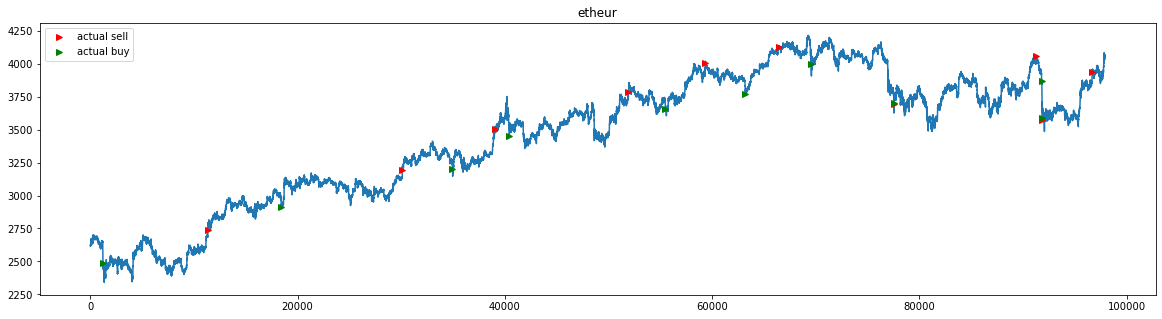

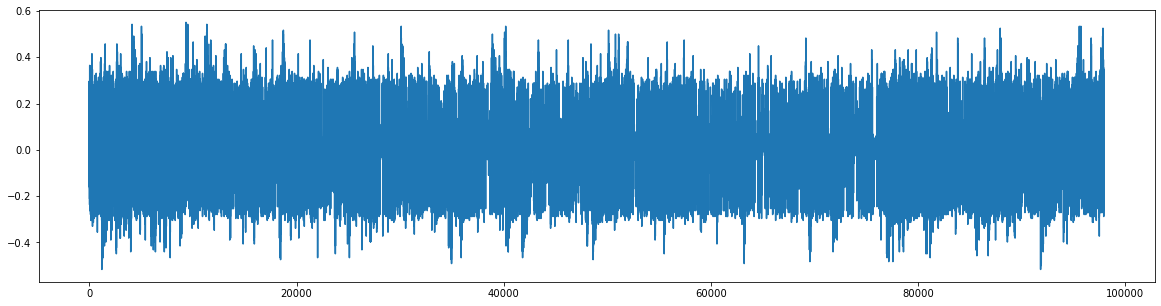

          time  action      cost  comment
0   1632461160       0 -1.613458        0
1   1632475680       1  1.486630        2
2   1632475740       0 -1.502868        0
3   1632641760       1  1.373086        2
4   1632642840       0 -1.364366        0
5   1632655620       1  1.466012        1
6   1632761340       0 -1.474605        0
7   1632871020       1  1.348046        2
8   1632872700       0 -1.347408        0
9   1632889200       1  1.416641       -1
10  1633217700       0 -1.535538        0
11  1633272300       1  1.669406        1
12  1633347000       0 -1.683768        0
13  1633509420       1  1.539398        2
14  1633559340       0 -1.582334        0
15  1633704120       1  1.715700        1
16  1633726560       0 -1.650094        0
17  1633967220       1  1.509318        2
18  1633982580       0 -1.479012        0
19  1634222520       1  1.611010        1
20  1634502240       0 -1.515006        0
21  1634883900       1  1.641000        1
22  1634939400       0 -1.584533  

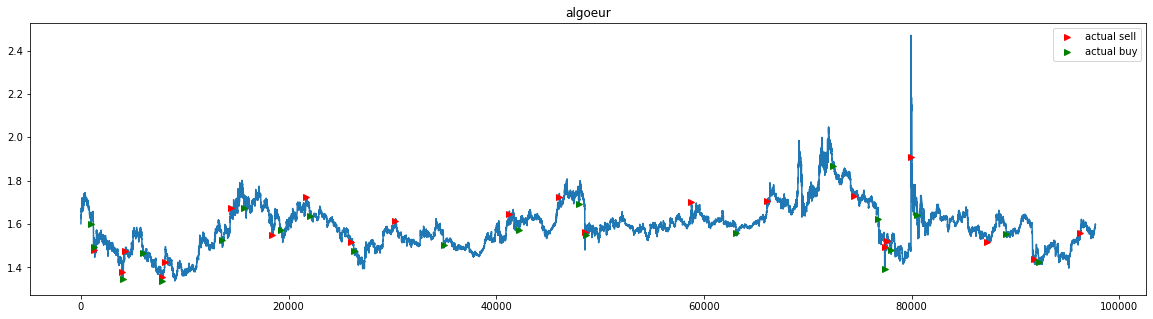

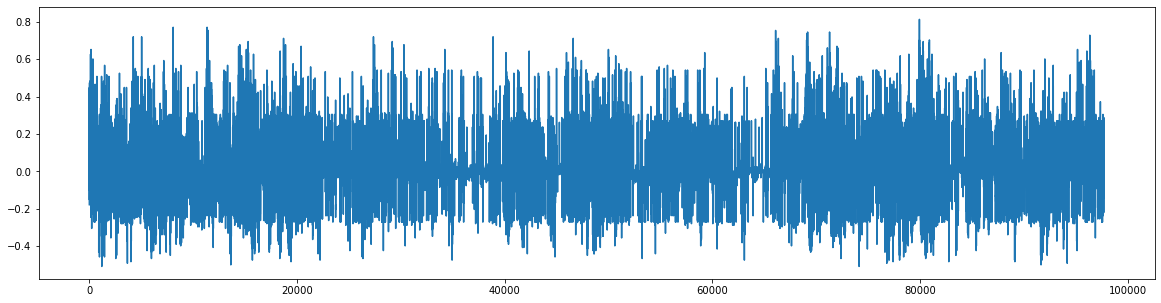

          time  action      cost  comment
0   1632475800       0 -0.554650        0
1   1632838740       1  0.505181        2
2   1633359840       0 -0.597189        0
3   1633651380       1  0.663655        1
4   1633910640       0 -0.619819        0
5   1635322200       1  0.563387        2
6   1635322560       0 -0.570011        0
7   1635478260       1  0.618715        1
8   1635657300       0 -0.999884        0
9   1635675000       1  0.911011        2
10  1635685140       0 -0.887405        0
11  1635762540       1  0.904019       -1
12  1635789840       0 -0.853561        0
13  1635818160       1  0.918671       -1
14  1635915360       0 -0.851693        0
15  1636027500       1  0.865833       -1
16  1636039140       0 -0.825589        0
17  1636387140       1  0.921111        1
18  1636440780       0 -1.057071        0
19  1636461000       1  1.105829       -1
20  1636477620       0 -1.030716        0
21  1636577640       1  0.945891        2
22  1636577820       0 -0.954523  

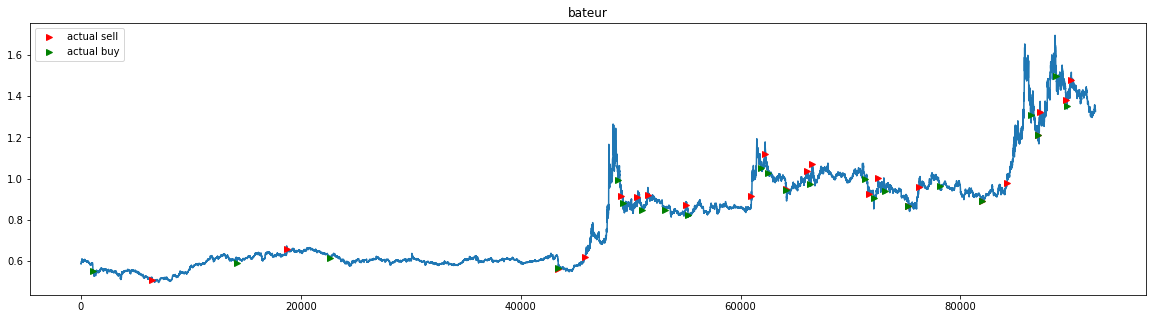

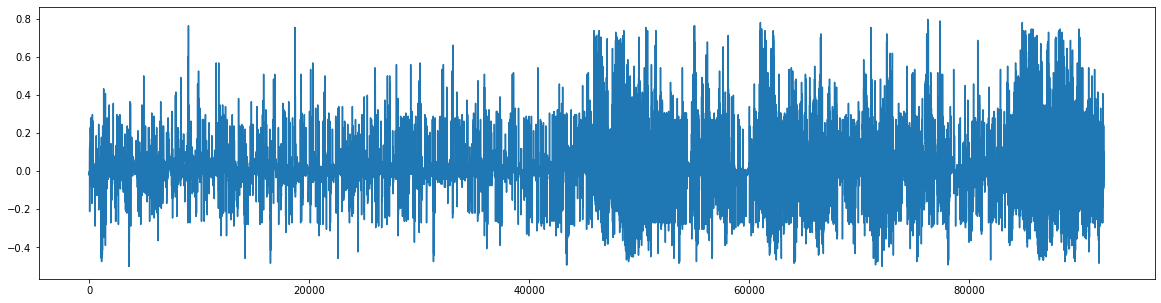

          time  action      cost  comment
0   1632617280       0 -1.940111        0
1   1632839820       1  1.778906        2
2   1632849600       0 -1.751273        0
3   1633084380       1  1.889332       -1
4   1633316580       0 -1.894012        0
5   1633594740       1  1.977707       -1
6   1634008260       0 -1.811665        0
7   1634310840       1  1.913413       -1
8   1635352200       0 -1.686720        0
9   1635410700       1  1.735260       -1
10  1635633480       0 -1.677799        0
11  1635917100       1  1.776811       -1
12  1637026560       0 -1.714062        0
13  1637057640       1  1.559414        2
14  1637249220       0 -1.582028        0
15  1637409660       1  1.712403        1
16  1637721120       0 -1.520056        0
17  1637845440       1  1.534845       -1
18  1637916720       0 -1.362508        0
19  1638134340       1  1.359527       -1
0.16747538952543067


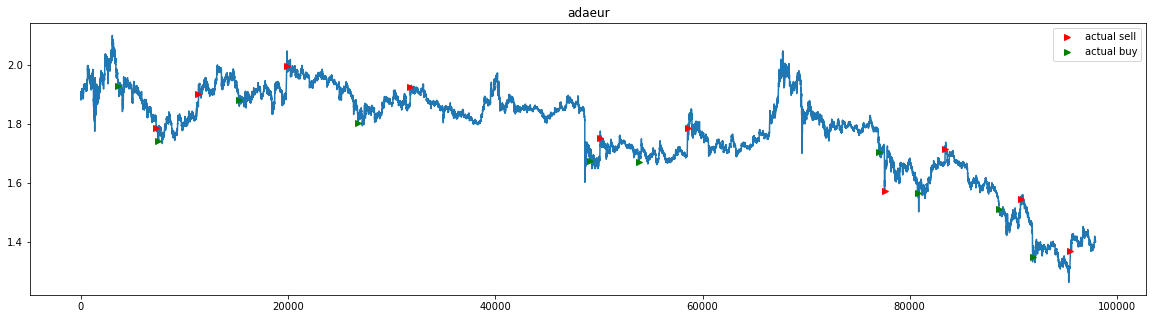

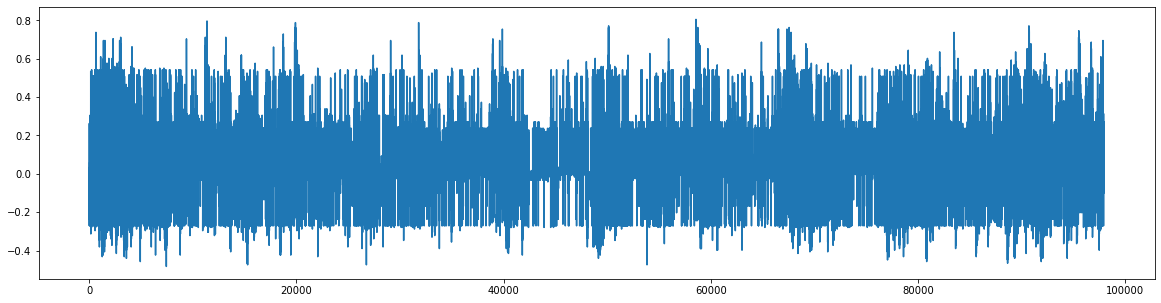

          time  action      cost  comment
0   1632474420       0 -0.824013        0
1   1632920940       1  0.843761       -1
2   1633509660       0 -0.890548        0
3   1633526040       1  0.923651       -1
4   1633909920       0 -0.984864        0
5   1634502060       1  0.877396        2
6   1634502660       0 -0.916532        0
7   1634815920       1  0.993112        1
8   1635321000       0 -0.938740        0
9   1635322200       1  0.850265        2
10  1635733500       0 -0.951019        0
11  1635914760       1  1.028101        1
12  1636198980       0 -0.982846        0
13  1636330980       1  1.066427        1
14  1636586820       0 -1.031379        0
15  1637057160       1  0.949736        2
16  1637228280       0 -0.957987        0
17  1637333640       1  0.963202       -1
18  1637912460       0 -0.906371        0
19  1637914920       1  0.837148        2
20  1638067560       0 -0.805318        0
21  1638166080       1  0.873143        1
0.0173389744773501


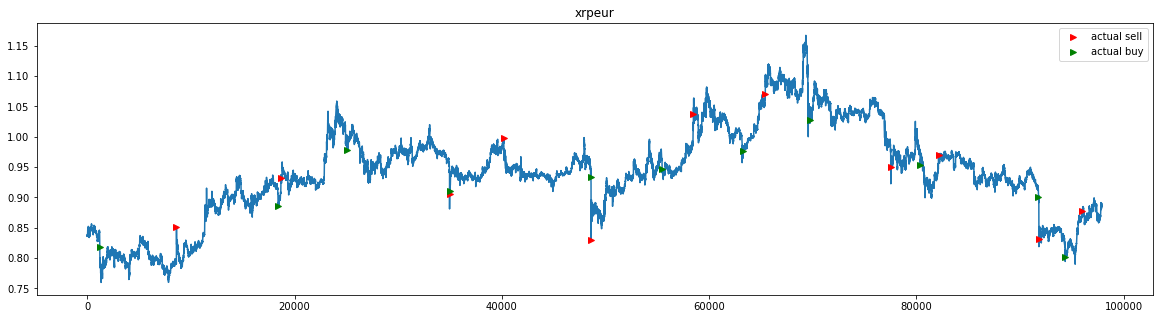

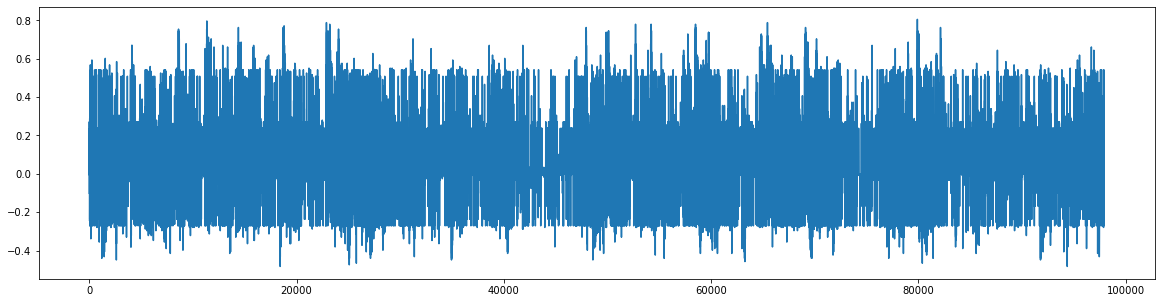

          time  action       cost  comment
0   1632475020       0 -442.36240        0
1   1632872940       1  403.67880        2
2   1633359480       0 -465.15320        0
3   1633457820       1  502.98000        1
4   1633508460       0 -500.44380        0
5   1633598160       1  545.50920        1
6   1633899960       0 -511.09624        0
7   1634376240       1  553.85568        1
8   1634502120       0 -513.78696        0
9   1634776860       1  555.23016        1
10  1634911440       0 -534.45932        0
11  1635321900       1  489.24516        2
12  1635322260       0 -478.21524        0
13  1635577500       1  514.93200        1
14  1635733860       0 -506.51800        0
15  1636406640       1  548.13864        1
16  1636577640       0 -597.99244        0
17  1637032980       1  546.54504        2
18  1637056980       0 -535.39304        0
19  1637249040       1  488.25912        2
20  1637249160       0 -493.15476        0
21  1637768520       1  535.53924        1
22  1637912

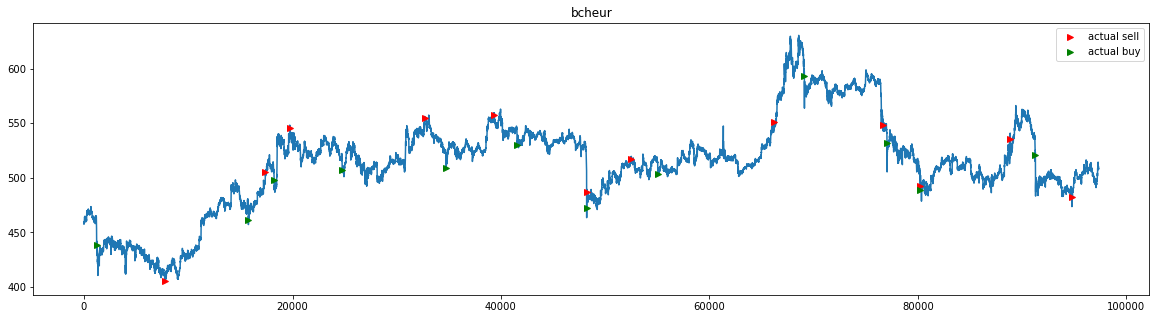

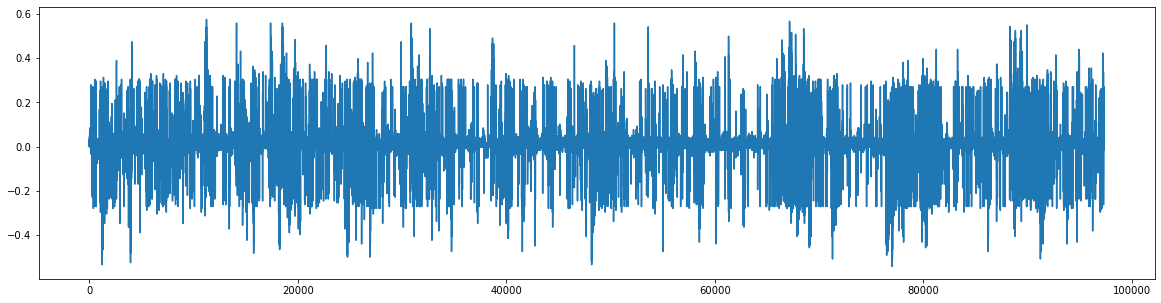

          time  action       cost  comment
0   1632461160       0 -308.10752        0
1   1632480300       1  281.94768        2
2   1632480480       0 -284.20228        0
3   1632706560       1  310.05480        1
4   1632957300       0 -257.64648        0
5   1633084740       1  281.74848        1
6   1633295280       0 -280.10596        0
7   1633507740       1  257.84448        2
8   1633508880       0 -256.63244        0
9   1633640100       1  279.31824        1
10  1633727280       0 -273.72052        0
11  1634008440       1  251.89836        2
12  1634104740       0 -258.45972        0
13  1634376240       1  280.13496        1
14  1634502180       0 -261.69260        0
15  1634779380       1  283.70064        1
16  1634826360       0 -275.69840        0
17  1635218880       1  297.26616        1
18  1635321900       0 -276.43132        0
19  1635673680       1  300.08484        1
20  1635943980       0 -310.42676        0
21  1635953880       1  336.11016        1
22  1636039

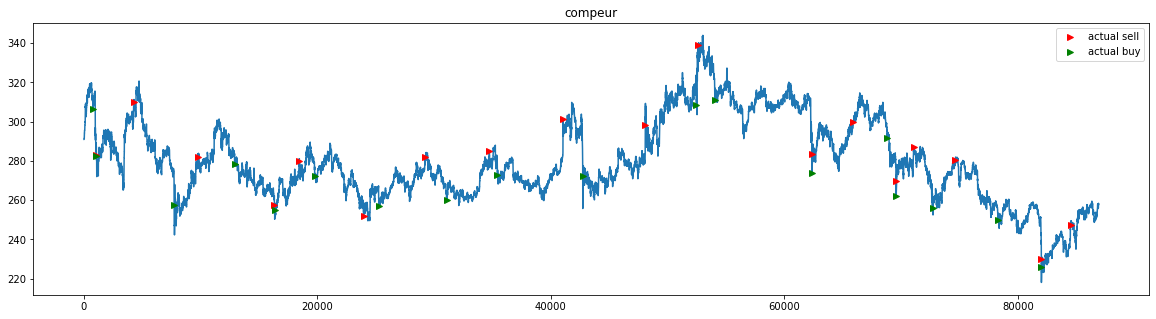

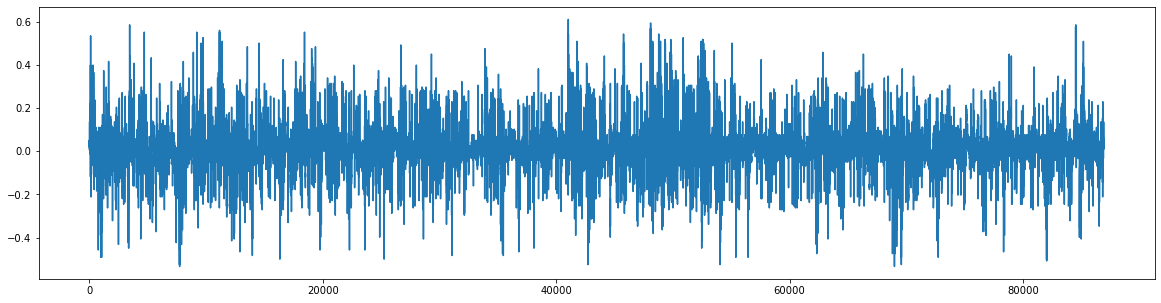

          time  action      cost  comment
0   1632477660       0 -0.175631        0
1   1633084380       1  0.180523       -1
2   1633567140       0 -0.212289        0
3   1633684980       1  0.217094       -1
4   1633899960       0 -0.204009        0
5   1634325000       1  0.207536       -1
6   1634502960       0 -0.198161        0
7   1634509620       1  0.206108       -1
8   1634912040       0 -0.206113        0
9   1635075240       1  0.223434        1
10  1635288780       0 -0.220784        0
11  1635321900       1  0.200928        2
12  1635326220       0 -0.200975        0
13  1635345900       1  0.220541        1
14  1635633000       0 -0.228151        0
15  1635705180       1  0.242796       -1
16  1635943620       0 -0.230956        0
17  1636102200       1  0.232394       -1
18  1636196820       0 -0.220581        0
19  1636359060       1  0.241713        1
20  1636581420       0 -0.216366        0
21  1636643760       1  0.233418        1
22  1636709640       0 -0.224910  

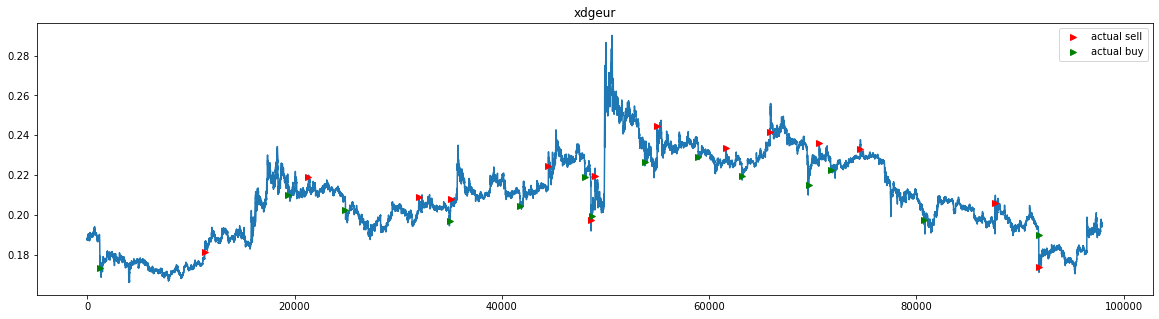

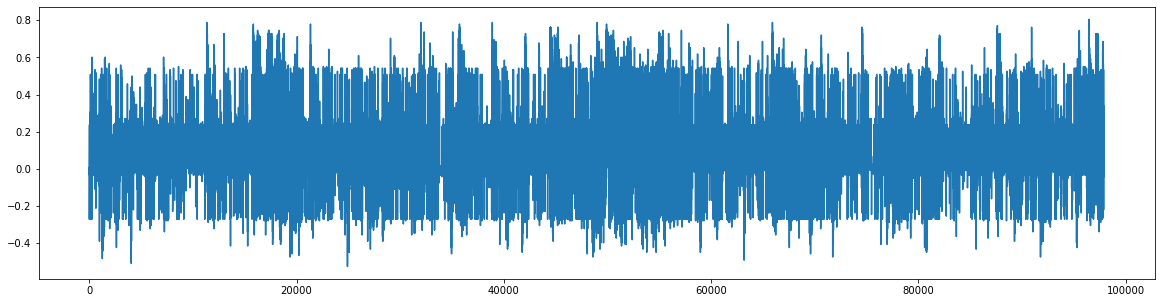

         time  action      cost  comment
0  1632476580       0 -0.242187        0
1  1632838680       1  0.221525        2
2  1633900740       0 -0.292052        0
3  1634135340       1  0.317265        1
0.01684760582855097


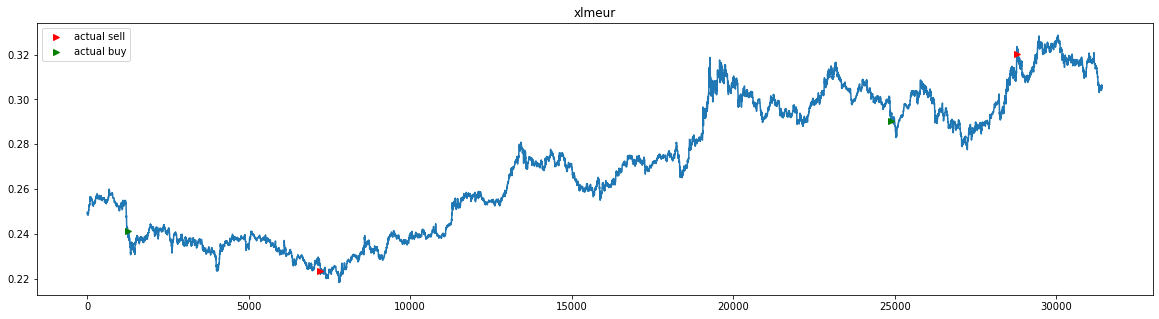

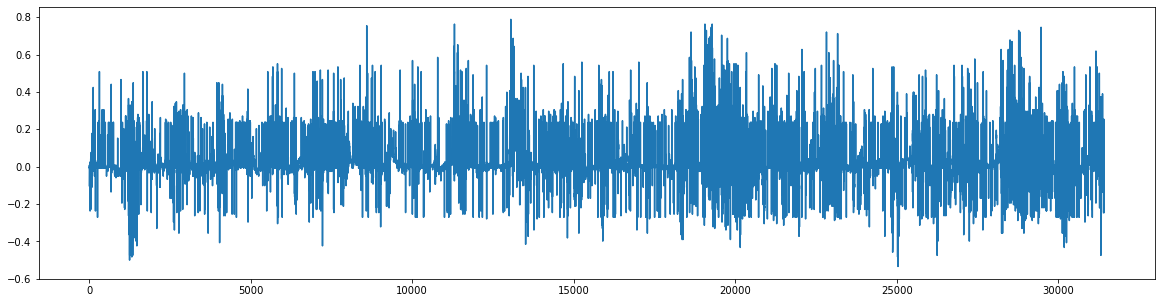

In [49]:
#df["preds"] = df[features[study.best_params["feature_n"]]]
list_acc=[]
for pair_name in crypto_to_evaluate+crypto_to_optimize:
    df_backtest = df[df.pair_name==pair_name]
    actions = backtest_numba_buy_and_sell(
        indexes= df_backtest.time.values,
        open_values=df_backtest.open.values,
        preds_values=df_backtest.preds.values,
        **study.best_params
    )
    actions_df = pd.DataFrame(actions, columns=["time", "action", "cost", "comment"])
    df_backtest = df_backtest.merge(actions_df, how="left", on="time")
    print(actions_df)
    print(actions_df.cost.sum()/df_backtest.open.mean())
    list_acc.append(actions_df.cost.sum()/df_backtest.open.mean())
    plt.figure(figsize=(20,5))
    plt.plot(df_backtest.open)
    plt.plot(df_backtest[df_backtest.action==1].open, ">r", label="actual sell")
    plt.plot(df_backtest[df_backtest.action==0].open, ">g", label="actual buy")
    plt.legend()
    plt.title(pair_name)
    plt.show()

    plt.figure(figsize=(20,5))
    plt.plot(df_backtest.preds)
    plt.show()

In [15]:
np.array(list_acc).mean()

nan

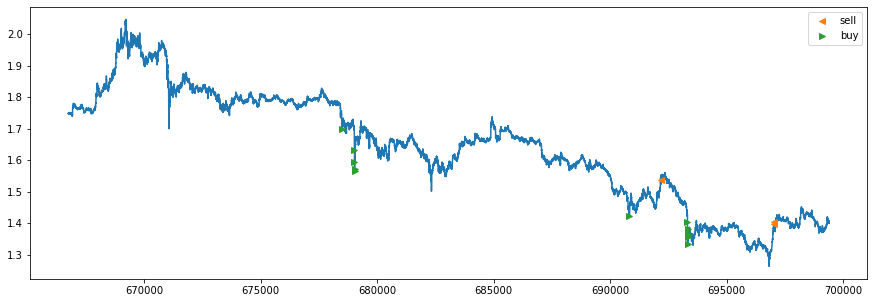

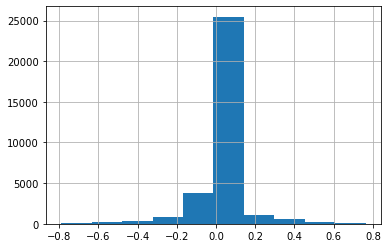

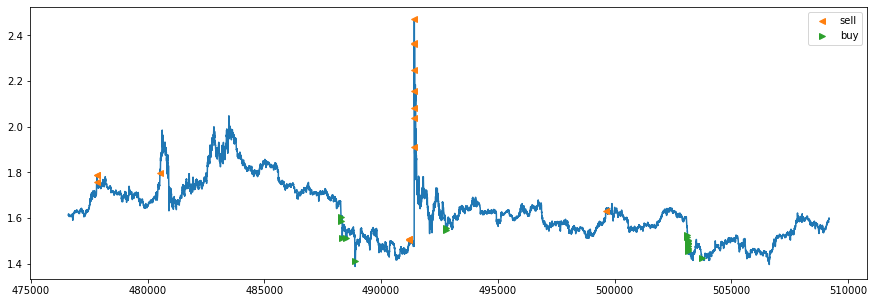

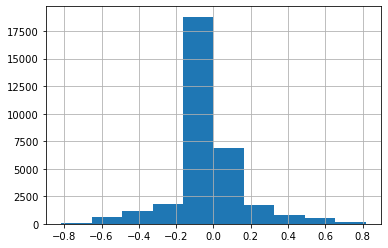

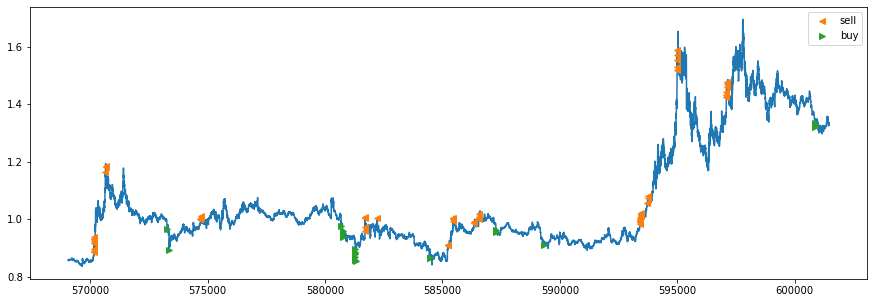

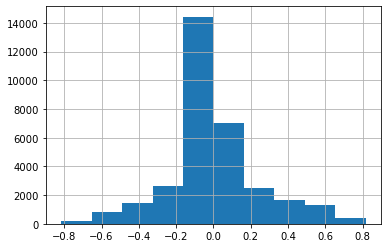

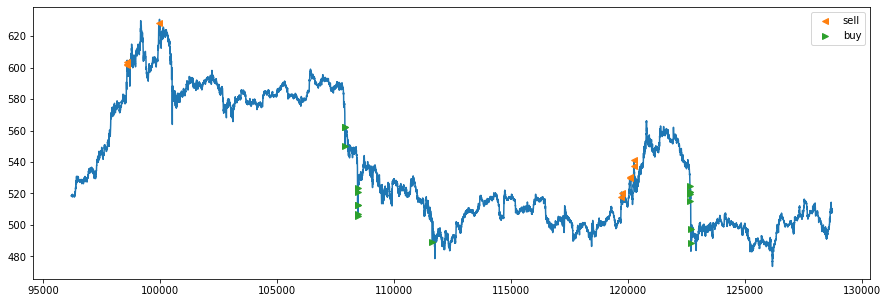

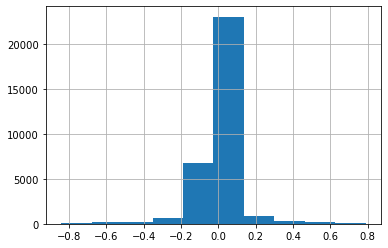

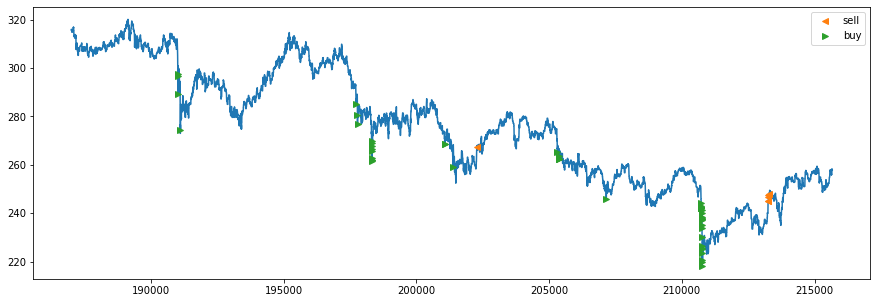

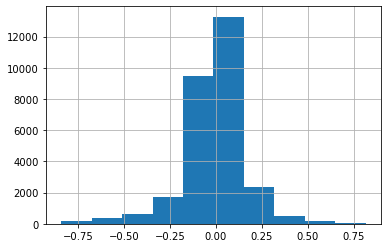

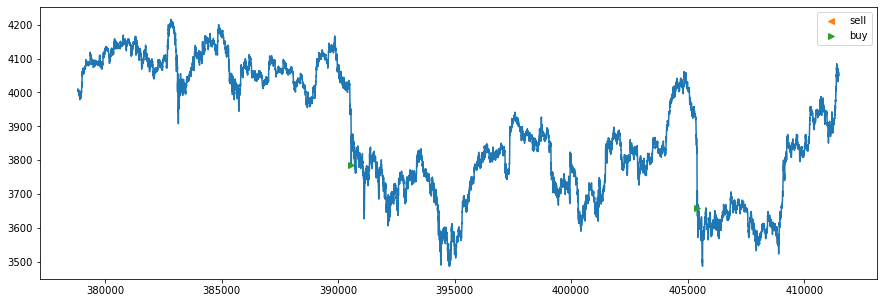

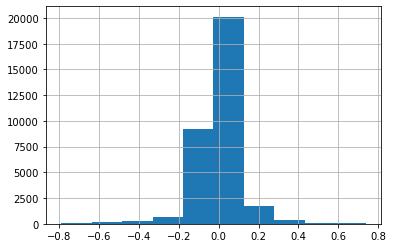

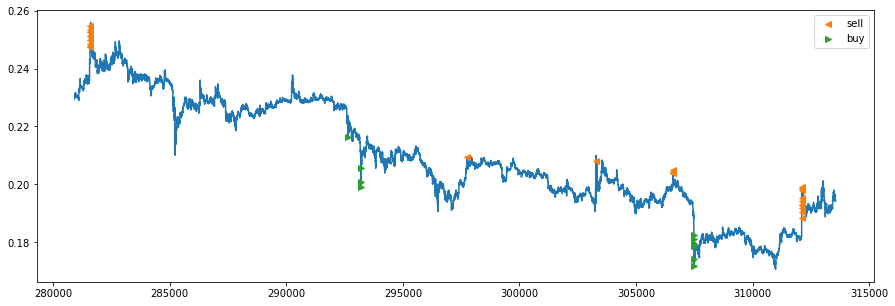

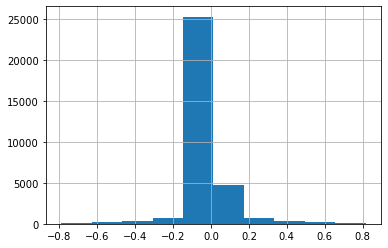

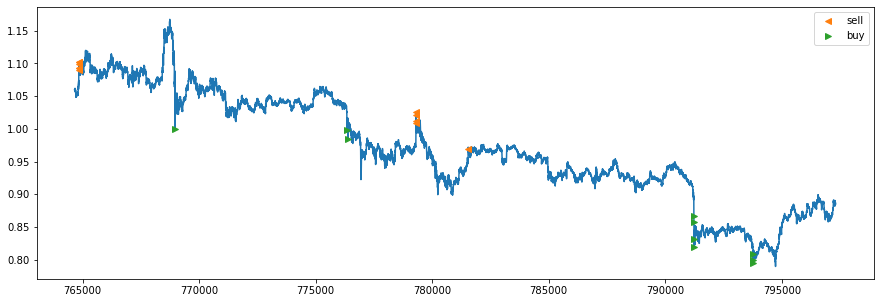

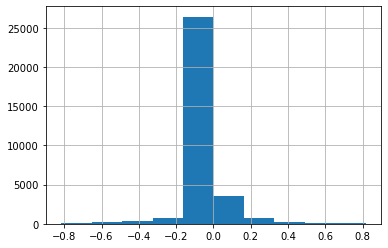

In [16]:
lim=0.75
for name, df_plot in df_optuna.groupby("pair_name"):
    plt.figure(figsize=(15,5))
    plt.plot(df_plot.open)
    plt.plot(df_plot[df_plot.preds>lim].open, "<", label="sell")
    plt.plot(df_plot[df_plot.preds<-lim].open, ">", label="buy")
    plt.legend()
    plt.show()
    df_plot.preds.hist()
    plt.show()

In [17]:
df_processed.mean(axis=1).plot()

NameError: name 'df_processed' is not defined

In [ ]:
1638029100

In [ ]:
df_backtest

Is there any shift in the preds?

In [ ]:
df_all["preds"] = model.predict(df_all[columns_features])

In [ ]:
cut_off_date ="2021-10-23 21:28:00"
for name, df_group in df_all.groupby("pair_name"):
    plt.figure()
    plt.title(name)
    df_group[df_group.date<cut_off_date].preds.hist(bins=50, alpha=0.5)
    df_group[df_group.date>cut_off_date].preds.hist(bins=50, alpha=0.5)
    plt.legend(["training", "live"])
    plt.show()
    print(df_group[df_group.date<cut_off_date].preds.max(),df_group[df_group.date>cut_off_date].preds.max() )
    print(df_group[df_group.date<cut_off_date].preds.min(),df_group[df_group.date>cut_off_date].preds.min() )

In [ ]:
study.best_params, study.best_value

In [ ]:

import numpy as np
np.array([1,2]).mean()

In [ ]:
df["preds"] = model.predict(df[columns_features])

In [ ]:
crypto_to_evaluate

In [ ]:
df_test = df[df.pair_name=="xlmeur"].copy()

In [ ]:
strategy = Strategy(**study.best_params)
strategy = Strategy(**{'take_profit_pct': 0.04,
  'stop_loss_pct': 0.04,
  'lim_pred_sell': 3,
  'lim_pred_buy': -3})

In [ ]:
df_backtest = strategy.backtest(df_test[["open", "preds"]])

In [ ]:
#%time df_backtest = strategy.backtest(df_test)

In [ ]:
#for market_action_pct in [0.01,0.02,0.03, 0.04, 0.05, 1]:
#    strategy = Strategy(take_profit_pct=market_action_pct, stop_loss_pct=market_action_pct, security_factor=0.000)
#    df_backtest = strategy.backtest(df_test)
#    profit = df_backtest["cost"].sum()/df_backtest["open"].mean()
#    hist_ratio = df_backtest.tail(1).open.values[0]/df_backtest.head(1).open.values[0]-1
#    print("stop and take", market_action_pct)
#    print("profit and hist", profit," and ",  hist_ratio)
#    print(df_backtest.strategy_action.value_counts())
    #print(df_backtest.comment.value_counts())

In [ ]:
df_backtest[df_backtest.cost.notnull()]

In [ ]:
import pandas as pd
class Strategy:
    def __init__(
        self,
        take_profit_pct: float = 0,
        stop_loss_pct:float=0,
        wait_time_after_action: int=0,
        pred_column_name: str="preds",
        lim_pred_sell: float=3,
        lim_pred_buy:float=-3,
        security_factor:float=0.0024
):
        self.take_profit_pct=take_profit_pct
        self.stop_loss_pct=stop_loss_pct
        self.wait_time_after_action=wait_time_after_action
        self.pred_column_name=pred_column_name
        self.lim_pred_sell=lim_pred_sell
        self.lim_pred_buy=lim_pred_buy
        self.fee=0.0016
        self.security_factor=security_factor
        
    def backtest(self, df: pd.DataFrame):
        df = df.copy()
        if self.pred_column_name not in df.columns:
            raise KeyError(f"{self.pred_column_name} not in columns")
        # asign action to predicted_action column
        df = self._add_predicted_action(df)
        # asign take profit or stop loss
        df["strategy_action"] = None
        df["comment"] = None
        df["cost"] = None
        next_action = "buy"
        previous_price = 0

        for index, row in df.iterrows():
            if (row["open"]>(1+self.take_profit_pct)*previous_price) and next_action=="sell":
                df.loc[df.index==index,"strategy_action"] = "sell"
                df.loc[df.index==index,"cost"] = row["open"]*(1-self.fee-self.security_factor)
                df.loc[df.index==index,"comment"] = "take_profit_triggered"
                next_action = "buy"
                previous_price = row["open"]
            
            elif (row["open"]<(1-self.stop_loss_pct)*previous_price) and next_action=="sell":
                df.loc[df.index==index,"strategy_action"] = "sell"
                df.loc[df.index==index,"cost"] = row["open"]*(1-self.fee-self.security_factor) #-row["open"]*(1+self.fee+self.security_factor)
                df.loc[df.index==index,"comment"] = "stop_loss_triggered"
                next_action = "buy"
                previous_price = row["open"]
            elif row["predicted_action"]=="buy" and next_action=="buy":
                df.loc[df.index==index,"strategy_action"] = "buy"
                df.loc[df.index==index,"cost"] = -row["open"]*(1+self.fee+self.security_factor)
                df.loc[df.index==index,"comment"] = "buy_predicted"
                next_action = "sell"
                previous_price = row["open"]
                
        df = self._equalize_buys_and_sells(df)

        return df
    def _add_predicted_action(self,df):
        df["predicted_action"] = None
        df.loc[df[self.pred_column_name]>self.lim_pred_sell, "predicted_action"] = "sell"
        df.loc[df[self.pred_column_name]<self.lim_pred_buy, "predicted_action"] = "buy"
        return df
    
    def _equalize_buys_and_sells(self, df):
        if df[df.strategy_action.notnull()].tail(1).strategy_action.values[0]=="buy":
            df.loc[df[df.strategy_action.notnull()].tail(1).index, ["cost", "strategy_action"]] = None
        return df
        
    

In [ ]:
df_backtest["cost"].sum()

In [ ]:
print("sum", df_backtest.cost.sum())
print(df_backtest.strategy_action.value_counts())

In [ ]:
df_backtest[df_backtest.cost.notnull()][["open", "comment", "strategy_action", "cost"]]

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df_backtest.open)
plt.plot(df_backtest[df_backtest.predicted_action=="sell"].open, ">r", label="actual sell")
plt.plot(df_backtest[df_backtest.predicted_action=="buy"].open, ">g", label="actual buy")
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtest.open)
plt.plot(df_backtest[df_backtest.strategy_action=="sell"].open, ">r", label="actual sell")
plt.plot(df_backtest[df_backtest.strategy_action=="buy"].open, ">g", label="actual buy")
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtest.preds)
plt.show()

In [ ]:
df_backtest.preds.plot()